In [0]:
!/opt/bin/nvidia-smi
!nvcc --version

Thu Mar 26 16:40:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
  !curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import os
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks import SaveModelCallback

# Imports for diverse utilities
from shutil import copyfile
import matplotlib.pyplot as plt
import operator
from PIL import Image
from sys import intern

In [0]:
!wget 'https://fyp-content-bucket.s3.amazonaws.com/CASIA_ELA.zip.7z'

--2020-03-26 16:40:44--  https://fyp-content-bucket.s3.amazonaws.com/CASIA_ELA.zip.7z
Resolving fyp-content-bucket.s3.amazonaws.com (fyp-content-bucket.s3.amazonaws.com)... 52.216.99.11
Connecting to fyp-content-bucket.s3.amazonaws.com (fyp-content-bucket.s3.amazonaws.com)|52.216.99.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1375594296 (1.3G) [application/x-7z-compressed]
Saving to: ‘CASIA_ELA.zip.7z’

CASIA_ELA.zip.7z    100%[===================>]   1.28G  16.9MB/s    in 82s     

2020-03-26 16:42:06 (16.1 MB/s) - ‘CASIA_ELA.zip.7z’ saved [1375594296/1375594296]



In [0]:
!7z e CASIA_ELA.zip.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 1375594296 bytes (1312 MiB)

Extracting archive: CASIA_ELA.zip.7z
--
Path = CASIA_ELA.zip.7z
Type = 7z
Physical Size = 1375594296
Headers Size = 130
Method = LZMA2:26
Solid = -
Blocks = 1

  0%      3% - CASIA_ELA.zip                      6% - CASIA_ELA.zip                      9% - CASIA_ELA.zip                     13% - CASIA_ELA.zip                     15% - CASIA_ELA.zip                     19% - CASIA_ELA.zip                     25% - CASIA_ELA.zip

In [0]:
!unzip -o -q CASIA_ELA.zip

In [0]:
def exportStageTo(learn, path):
    learn.export()
    copyfile(path/'export.pkl', path/'export-ela.pkl')

def restoreStageFrom(path):
    # Restore a backup
    copyfile(path/'export-ela.pkl', path/'export.pkl')
    return load_learner(path)

In [0]:
path = Path("/root/.fastai/data/CASIA_ELA"); path

PosixPath('/root/.fastai/data/CASIA_ELA')

In [0]:
path_to_test = Path("/root/.fastai/data/CASIA_ELA/Test")
test = ImageList.from_folder(path_to_test)

In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_rotate=None, max_warp=None, max_zoom=1.0)

In [0]:
# Batch Size
bs = 64
# Image size, 448x448
size = 448
data = ImageDataBunch.from_folder(path, train='Train', valid='Valid', 
                                  ds_tfms = tfms, size=size, bs=bs)

data.save('imageDataBunch-bs-'+str(bs)+'-size-'+str(size)+'.pkl')

In [0]:
print('Transforms = ', len(tfms))
print(data.classes)
data

Transforms =  2
['Authentic', 'Tampered']


ImageDataBunch;

Train: LabelList (7605 items)
x: ImageList
Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448)
y: CategoryList
Authentic,Authentic,Authentic,Authentic,Authentic
Path: /root/.fastai/data/CASIA_ELA;

Valid: LabelList (4163 items)
x: ImageList
Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448),Image (3, 448, 448)
y: CategoryList
Authentic,Authentic,Authentic,Authentic,Authentic
Path: /root/.fastai/data/CASIA_ELA;

Test: None

In [0]:
data.show_batch(rows=5, figsize=(15,15))

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=[accuracy, error_rate])
# learn.model

In [0]:
learn.fit_one_cycle(10, callbacks=[SaveModelCallback(learn, every='epoch', 
                                                     monitor='accuracy', 
                                                     name='ela-1')])
learn.save('ela-stage-1')

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.445113,0.293807,0.902234,0.097766,05:29
1,0.315697,0.249912,0.886860,0.113140,05:22
2,0.250142,0.190986,0.912563,0.087437,05:14
3,0.226385,0.175012,0.919769,0.080231,05:20
4,0.197307,0.188076,0.911602,0.088398,05:15
5,0.180686,0.168633,0.929138,0.070862,05:08
6,0.168288,0.157735,0.932741,0.067259,05:14
7,0.158068,0.145430,0.934663,0.065337,05:12
8,0.145443,0.143305,0.933461,0.066539,05:09
9,0.144329,0.143004,0.934182,0.065818,05:16


In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

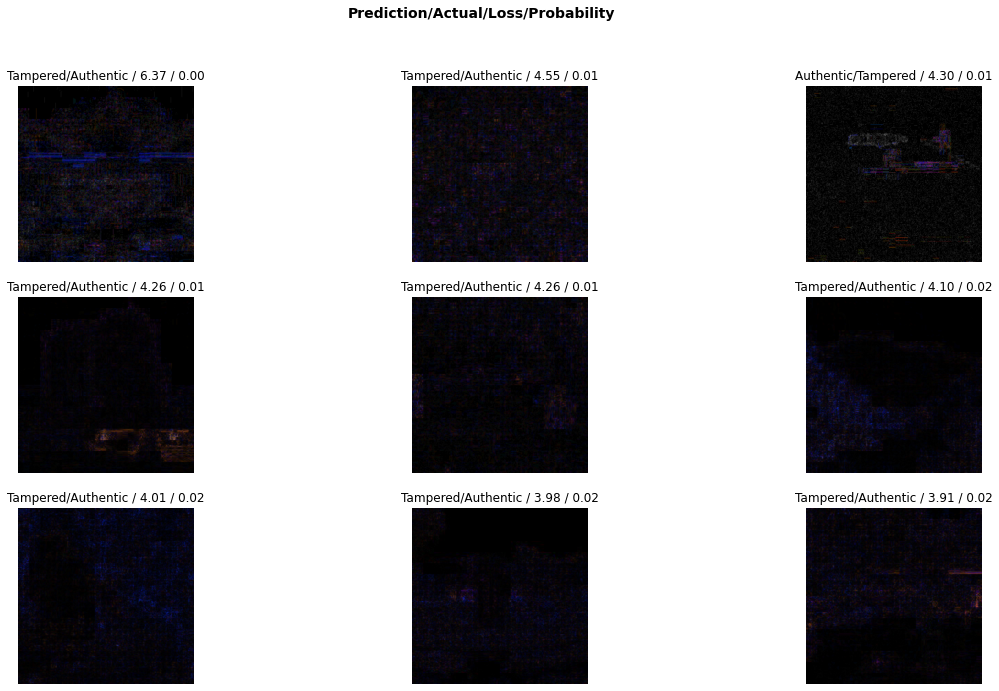

In [0]:
interp.plot_top_losses(9, figsize=(20,11), heatmap=False)

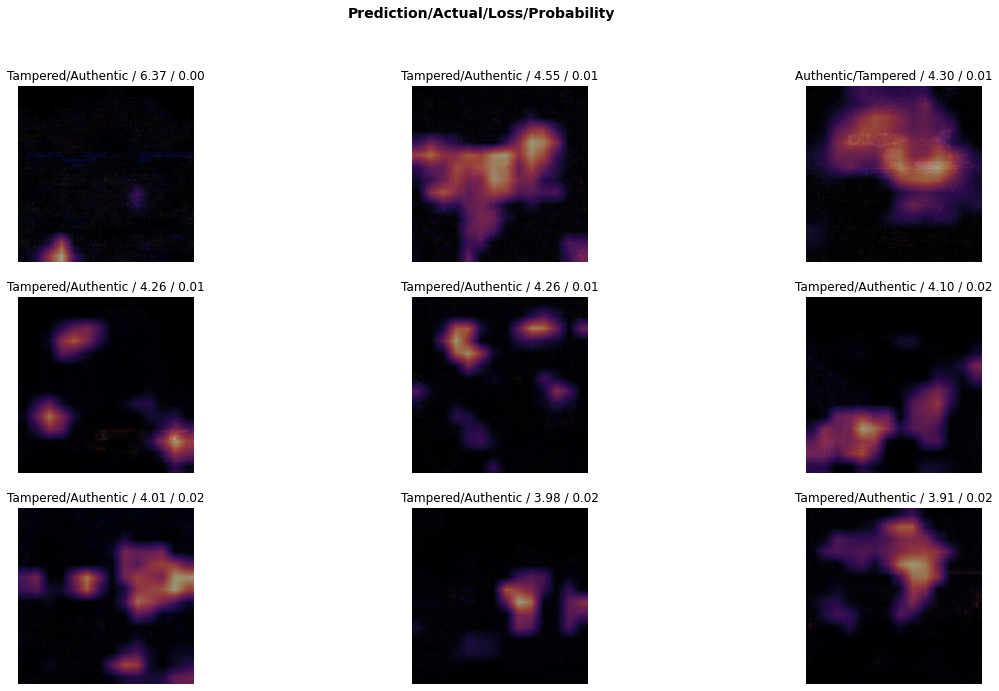

In [0]:
interp.plot_top_losses(9, figsize=(20,11), heatmap=True)

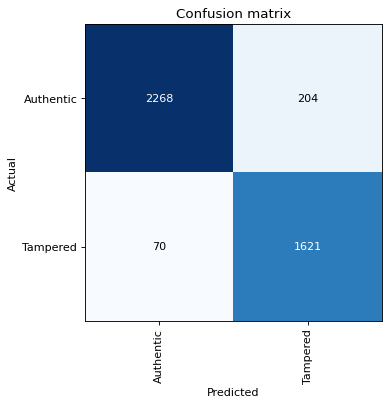

In [0]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=80)

In [0]:
losses

tensor([6.3726, 4.5531, 4.2979,  ..., -0.0000, -0.0000, -0.0000])

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


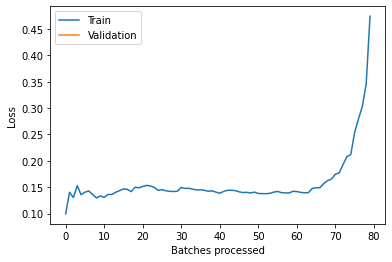

In [0]:
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-06
Min loss divided by 10: 6.92E-07


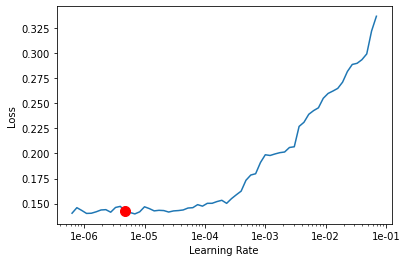

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
learn.unfreeze()

learn.fit_one_cycle(30, max_lr=slice(1e-4,1e-5), 
                    callbacks=[SaveModelCallback(learn, 
                                                 every='epoch', 
                                                 monitor='accuracy', 
                                                 name='ela')])
learn.save('ela-stage-2')

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.140826,0.140979,0.934663,0.065337,05:40
1,0.138272,0.137195,0.940187,0.059813,05:38
2,0.138078,0.137245,0.938746,0.061254,05:39
3,0.130574,0.133654,0.942589,0.057411,05:36
4,0.124160,0.131084,0.942589,0.057411,05:37
5,0.124040,0.128546,0.943550,0.056450,05:35
6,0.107504,0.127593,0.952438,0.047562,05:33
7,0.107404,0.176500,0.932260,0.067740,05:31
8,0.104318,0.141555,0.938986,0.061014,05:31
9,0.094279,0.108429,0.959885,0.040115,05:32


In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

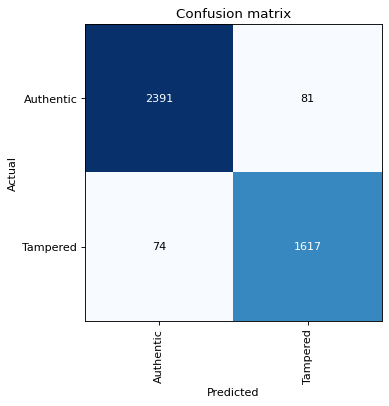

In [0]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=80)

Get Predictions and accuracy on the test dataset

In [0]:
learn = load_learner(path)

In [0]:
path = '/content/data/CASIA_ELA/Test/'
folders = os.listdir(path)

count_fake = 0
count_real = 0

conf_list = []

for folder in folders:
    if os.path.isdir(path + folder):
        new_path = os.path.join(path + folder + '/')
        print(new_path)
        for f in os.listdir(new_path):
            img = open_image(new_path + f)
            pred_class,pred_idx,confidence = learn.predict(img)
            if str(pred_class) == 'Tampered':
                if 'Tampered' == folder:
                    count_fake += 1
                conf = float(confidence[1])
            elif str(pred_class) == 'Authentic':
                if 'Authentic' == folder:
                    count_real += 1
                conf = float(confidence[0])
            conf = conf * 100
            
            conf_list.append(conf)
    
            # if conf >=65:
            #     print('Predicted: {} ------ Confidence: {:.3f}% ------ Actual: {}'.format(pred_class, conf, folder))
            
            

/content/data/CASIA_ELA/Test/Authentic/
/content/data/CASIA_ELA/Test/Tampered/


In [0]:
total_fake = len(os.listdir(str(path) + '/Tampered/'))
total_real = len(os.listdir(str(path) + '/Authentic/'))

In [0]:
accuracy_fake = (count_fake/total_fake) * 100
accuracy_real = (count_real/total_real) * 100

print('Images Classified As Authentic')
print('{}/{}. Accuracy = {:.2f}%'.format(count_real, total_real, accuracy_real))

print('Images Classified As Tampered')
print('{}/{}. Accuracy = {:.2f}%'.format(count_fake, total_fake, accuracy_fake))

Images Classified As Authentic
477/502. Accuracy = 95.02%
Images Classified As Tampered
325/344. Accuracy = 94.48%


In [0]:
average_conf = sum(conf_list) / len(conf_list)

print('Average confidence of the model = {:.3f}%'.format(average_conf))

Average confidence of the model = 97.606%


Predict on a single image

In [0]:
img = open_image('/content/data/CASIA_ELA/Test/Tampered/Tp_D_CRN_M_B_ani00019_nat00013_11868.ela.png')

In [0]:
pred_class,pred_idx,confidence = learn.predict(img); pred_class

Category Tampered

Create a heatmap of the image

In [0]:
!pip install Pillow --upgrade

Requirement already up-to-date: Pillow in /usr/local/lib/python3.6/dist-packages (7.0.0)


In [0]:
!pip install fastai2

In [0]:
from fastai.callbacks.hooks import *
from fastai2.vision.all import *

In [0]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [0]:
fn = Path("/root/.fastai/data/CASIA_ELA/Test/Tampered/Tp_D_CRN_M_B_ani00019_nat00013_11868.ela.png")

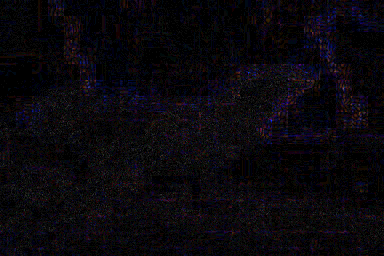

In [0]:
x = PILImage.create(fn); x